In [2]:
import pandas as pd
import geopandas as gpd

census_1996 = pd.read_csv("input-files/Census1996.csv")
census_2021 = pd.read_csv("input-files/Census2021.csv")
transit_buff_1996 = pd.read_csv("input-files/Transit Buffer With EA 1996.csv")
transit_buff_2021 = pd.read_csv("input-files/Transit Buffer With DA 2021.csv")
transit_points = pd.read_csv("input-files/transit-line-points.csv")


In [3]:
transit_buff_1996.columns.tolist()

['OBJECTID',
 'FID_PointBuffer',
 'ID',
 'ORIG_LEN',
 'NAME',
 'Station',
 'x',
 'y',
 'BUFF_DIST',
 'ORIG_FID',
 'FID_Census1996_Enu_Toronto',
 'EAUID',
 'SNF',
 'PRUID',
 'CMAUID',
 'Area',
 'Shape_Length',
 'Shape_Area',
 'TBuff_Area']

In [4]:
#join tables together
table_1996 = pd.merge(transit_buff_1996, census_1996, on = "EAUID")
table_2021 = pd.merge(transit_buff_2021, census_2021, on = "DAUID")


In [5]:
a=0
for i in table_2021.columns.tolist():
    print(a, i)
    a+=1

0 OBJECTID
1 FID_PointBuffer
2 ID
3 ORIG_LEN
4 NAME
5 Station
6 x
7 y
8 BUFF_DIST
9 ORIG_FID
10 FID_Census2021_Dis_Toronto
11 DAUID
12 DGUID
13 LANDAREA
14 PRUID
15 Area
16 Shape_Length
17 Shape_Area
18 TBuff_Area
19 Population
20 Total Occupied Dwelling
21 Single-detached
22 Semi-detached
23 Row House
24 Apartment or Duplex
25 Apartment fewer than 5 STY
26 Apartment greater than 5 STY
27 Other Single-Detached
28 Movable
29 Average Individual Income


In [6]:


list1996 = ["EAUID", "FID_PointBuffer",'TBuff_Area']
list1996.extend(table_1996.columns.tolist()[19:]) #add all the census variable fields
list2021 = ["DAUID", "FID_PointBuffer",'TBuff_Area']
list2021.extend(table_2021.columns.tolist()[19:]) #add all the census variable fields


In [7]:
census_alys_1996 = table_1996[list1996]
census_alys_2021 = table_2021[list2021]

In [8]:
census_alys_2021.columns.tolist()

['DAUID',
 'FID_PointBuffer',
 'TBuff_Area',
 'Population',
 'Total Occupied Dwelling',
 'Single-detached',
 'Semi-detached',
 'Row House',
 'Apartment or Duplex',
 'Apartment fewer than 5 STY',
 'Apartment greater than 5 STY',
 'Other Single-Detached',
 'Movable',
 'Average Individual Income']

In [9]:
#calculate the total buffer area to calculate weighted average income, 1996 numbers will be different from 2021, FID_PointBuffer is the buffer ID for each station
tbuffArea_1996 = pd.pivot_table(table_1996, values = ['TBuff_Area'], index = ['FID_PointBuffer'], aggfunc = "sum", sort = False).reset_index().rename(columns = {"TBuff_Area": "Total TBuff Area"})
tbuffArea_2021 = pd.pivot_table(table_2021, values = ['TBuff_Area'], index = ['FID_PointBuffer'], aggfunc = "sum", sort = False).reset_index().rename(columns = {"TBuff_Area": "Total TBuff Area"})
#join the pivot tables together.
census_alys_1996 = pd.merge(census_alys_1996, tbuffArea_1996, on = "FID_PointBuffer")
census_alys_2021 = pd.merge(census_alys_2021, tbuffArea_2021, on = "FID_PointBuffer")

In [10]:
census_alys_1996['TBuff_Area']

0           37.281761
1            0.193702
2         3624.276090
3         3178.903752
4        21692.190500
             ...     
44479      341.188184
44480      136.622496
44481     1088.038276
44482     1418.070735
44483     1260.541212
Name: TBuff_Area, Length: 44484, dtype: float64

In [11]:
#calculate the ratio of the buffer pieces to the total buffer area
census_alys_1996['Buff Ratio'] = census_alys_1996['TBuff_Area']/census_alys_1996['Total TBuff Area']
census_alys_2021['Buff Ratio'] = census_alys_2021['TBuff_Area']/census_alys_2021['Total TBuff Area']


In [12]:
#spatial interpolation
columnList1996 = census_alys_1996.columns.tolist()[3:-3]
columnList2021 = census_alys_2021.columns.tolist()[3:-3]

i=0
while i < len(columnList1996):
    census_alys_1996[f'Adjusted {columnList1996[i]}'] = census_alys_1996[columnList1996[i]]*census_alys_1996['Buff Ratio']
    census_alys_2021[f'Adjusted {columnList2021[i]}'] = census_alys_2021[columnList2021[i]]*census_alys_2021['Buff Ratio']
    i+=1

adjustedColumnList1996 = census_alys_1996.columns.tolist()[3+3+len(columnList1996):]
adjustedColumnList2021 = census_alys_2021.columns.tolist()[3+3+len(columnList2021):]

In [13]:
#Sum Population Within Transit Buffer (sum the adjusted population) to get the total population with transit buffer
tbuffpivot_1996 = pd.pivot_table(census_alys_1996, values = adjustedColumnList1996, index = ['FID_PointBuffer'], aggfunc = "sum", sort = False)
tbuffpivot_2021 = pd.pivot_table(census_alys_2021, values = adjustedColumnList2021, index = ['FID_PointBuffer'], aggfunc = "sum", sort = False)

i=0
while i < len(adjustedColumnList2021):
    
    tbuffpivot_1996 = tbuffpivot_1996.rename(columns = {f"{adjustedColumnList1996[i]}": f"TBuff {adjustedColumnList1996[i].replace('Adjusted ', '')} 1996"})
    tbuffpivot_2021 = tbuffpivot_2021.rename(columns = {f"{adjustedColumnList2021[i]}": f"TBuff {adjustedColumnList2021[i].replace('Adjusted ', '')} 2021"})
    i+=1

#join the pivot tables together
census_alys_1996 = pd.merge(census_alys_1996, tbuffpivot_1996, on = "FID_PointBuffer")
census_alys_2021 = pd.merge(census_alys_2021, tbuffpivot_2021, on = "FID_PointBuffer")

In [14]:
#Calculate the Population Weight for each buffer
census_alys_1996['Buffer Population Ratio'] = census_alys_1996['Adjusted Population'] / census_alys_1996['TBuff Population 1996']
census_alys_2021['Buffer Population Ratio'] = census_alys_2021['Adjusted Population'] / census_alys_2021['TBuff Population 2021']
#calculating adjusted income based on the buff ratio, then sum up to get weighted average income for each buffer
census_alys_1996['Adjusted Weighted Income 1996'] = census_alys_1996['Average Individual Income']*census_alys_1996['Buffer Population Ratio']
census_alys_2021['Adjusted Weighted Income 2021'] = census_alys_2021['Average Individual Income']*census_alys_2021['Buffer Population Ratio']
#sum by the adjusted weighted income
weighted_1996_list = census_alys_1996.columns.tolist()[26:-3]
weighted_1996_list.append("FID_PointBuffer")
weighted_2021_list = census_alys_2021.columns.tolist()[26:-3]
weighted_2021_list.append("FID_PointBuffer")


In [15]:

weighted_1996_income = pd.pivot_table(census_alys_1996, values = 'Adjusted Weighted Income 1996', index = weighted_1996_list,aggfunc = "sum", sort = False).reset_index()
weighted_2021_income = pd.pivot_table(census_alys_2021, values = 'Adjusted Weighted Income 2021', index = weighted_2021_list,aggfunc = "sum", sort = False).reset_index()


In [16]:
weighted_2021_income

,TBuff Population 2021,TBuff Total Occupied Dwelling 2021,TBuff Single-detached 2021,TBuff Semi-detached 2021,TBuff Row House 2021,TBuff Apartment or Duplex 2021,TBuff Apartment fewer than 5 STY 2021,TBuff Apartment greater than 5 STY 2021,TBuff Other Single-Detached 2021,FID_PointBuffer,Adjusted Weighted Income 2021
0,844.262729,307.208779,67.417196,26.464158,16.063275,25.926259,29.674140,135.270378,6.715749,2,40433.366231
1,1009.170631,341.209330,56.956029,32.470176,77.353306,22.046658,56.427996,93.069430,3.242053,3,46733.206669
2,919.011063,331.182847,94.764613,18.267565,12.978364,32.516736,27.584704,140.172472,5.332714,1,39173.908894
3,919.011063,331.182847,94.764613,18.267565,12.978364,32.516736,27.584704,140.172472,5.332714,68,39173.908894
4,1325.905220,430.865136,53.037484,42.551864,160.902215,18.233266,92.643814,59.971076,3.658229,4,50702.445832
...,...,...,...,...,...,...,...,...,...,...,...
351,724.481480,277.403235,184.577619,8.231054,3.274550,5.684556,10.791752,64.415160,0.000000,356,199638.782303
352,895.534430,372.255705,204.042716,1.242008,3.899179,3.740078,38.297812,121.139243,0.000000,357,170247.636544
353,1006.476490,437.504306,200.384501,0.120668,2.765395,2.240700,77.343624,154.332514,0.000000,358,128078.469478
354,1785.892522,1055.756856,0.996288,1.646401,1.791093,0.813938,37.344981,1012.774013,0.190090,332,81023.350981


In [17]:
weighted_1996_income.to_csv("exported-tables/weighted-1996-income.csv")
weighted_2021_income.to_csv("exported-tables/weighted-2021-income.csv")

In [18]:
#adjust for inflation to allow comparison
weighted_1996_income['Adjusted Weighted Income 1996'] = weighted_1996_income['Adjusted Weighted Income 1996']*1.562143 #1.562143 is the inflation coefficient between 1995 and 2020, from Bank of Canada

#join tables
transit_buffer = pd.merge(weighted_1996_income, weighted_2021_income, on = "FID_PointBuffer")



In [19]:
col = transit_buffer.pop('FID_PointBuffer')
transit_buffer.insert(0, "FID_PointBuffer", col)
transit_buffer

,FID_PointBuffer,TBuff Population 1996,TBuff Total Occupied Dwelling (20%) 1996,TBuff Single-detached (20%) 1996,TBuff Semi-detached (20%) 1996,TBuff Row House (20%) 1996,TBuff Apartment or Duplex (20%) 1996,TBuff Apartment fewer than 5 STY (20%) 1996,TBuff Apartment greater than 5 STY (20%) 1996,TBuff Other Single-Detached (20%) 1996,...,TBuff Population 2021,TBuff Total Occupied Dwelling 2021,TBuff Single-detached 2021,TBuff Semi-detached 2021,TBuff Row House 2021,TBuff Apartment or Duplex 2021,TBuff Apartment fewer than 5 STY 2021,TBuff Apartment greater than 5 STY 2021,TBuff Other Single-Detached 2021,Adjusted Weighted Income 2021
0,2,937.580287,326.259722,143.875679,34.991666,15.167731,11.142786,105.157383,13.670560,0.503059,...,844.262729,307.208779,67.417196,26.464158,16.063275,25.926259,29.674140,135.270378,6.715749,40433.366231
1,1,909.368272,308.867197,143.638127,23.075969,16.585579,15.878867,93.681189,14.047932,0.487607,...,919.011063,331.182847,94.764613,18.267565,12.978364,32.516736,27.584704,140.172472,5.332714,39173.908894
2,68,909.368272,308.867197,143.638127,23.075969,16.585579,15.878867,93.681189,14.047932,0.487607,...,919.011063,331.182847,94.764613,18.267565,12.978364,32.516736,27.584704,140.172472,5.332714,39173.908894
3,183,909.370037,308.868522,143.638935,23.075951,16.585593,15.878731,93.682191,14.047615,0.487601,...,919.015080,331.184515,94.765065,18.267514,12.978373,32.516940,27.584500,140.173652,5.332817,39173.951093
4,200,909.370037,308.868522,143.638935,23.075951,16.585593,15.878731,93.682191,14.047615,0.487601,...,919.015080,331.184515,94.765065,18.267514,12.978373,32.516940,27.584500,140.173652,5.332817,39173.951093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,355,860.082724,330.803548,236.715306,26.697728,1.856424,7.905795,0.851782,55.121966,1.117605,...,684.783004,259.721252,162.751647,20.920719,2.462088,6.816660,28.747303,36.193358,0.000000,184618.135885
352,356,938.002717,333.970775,278.540078,10.659150,2.277647,6.097277,6.280083,30.264394,0.496417,...,724.481480,277.403235,184.577619,8.231054,3.274550,5.684556,10.791752,64.415160,0.000000,199638.782303
353,357,1005.753097,345.440216,299.005036,0.787732,2.308100,2.406482,11.091063,31.816525,0.000000,...,895.534430,372.255705,204.042716,1.242008,3.899179,3.740078,38.297812,121.139243,0.000000,170247.636544
354,358,1059.938798,357.948132,303.088785,0.139315,1.261479,0.000000,12.525586,45.508654,0.000000,...,1006.476490,437.504306,200.384501,0.120668,2.765395,2.240700,77.343624,154.332514,0.000000,128078.469478


In [20]:
#Calculating Change
transit_bufferList = transit_buffer.columns.tolist()[1:]
listlen = int(len(transit_bufferList)/2)

i = 0 
while i < listlen:
    
    field = transit_bufferList[i].replace("TBuff ", "").replace("Adjusted ", "").replace(" 1996","").replace(" (20%)", "")
    transit_buffer[f'Percent {field} Chg'] = (transit_buffer[transit_bufferList[i+listlen]] - transit_buffer[transit_bufferList[i]]) /transit_buffer[transit_bufferList[i]] *100
    
    i+=1

#join to get x y coordinates
transit_buffer = pd.merge(transit_buffer, transit_points, right_on = "ID", left_on = "FID_PointBuffer")

In [22]:
transit_buffer.to_csv("exported-tables/transit_buffer.csv")
transit_buffer = pd.read_csv("exported-tables/transit_buffer.csv")

transit_buffer.to_json("web-transit-analysis/transit-analysis/src/data/transit_buffer.json")



Plotting the Data

DriverError: Points 400m/Points 400m.shp: No such file or directory

In [ ]:
point_400 = gpd.read_file("Points 400m/Points 400m.shp")
transit_buff_1996 = gpd.read_file("Transit Buffer 1996/Transit Buffer 1996.shp")
#transit_buff_1996 = 
transit_buff_2021 = gpd.read_file("Transit Buffer 2021/Transit Buffer 2021.shp")

In [ ]:
transit_buff_2021['DAUID'] = transit_buff_2021['DAUID'].astype('int')
transit_buff_2021_merge = pd.merge(transit_buff_2021, census_alys_2021, on = "DAUID")
point_400_join = pd.merge(point_400, transit_buffer, left_on = "ID", right_on = "FID_PointBuffer")

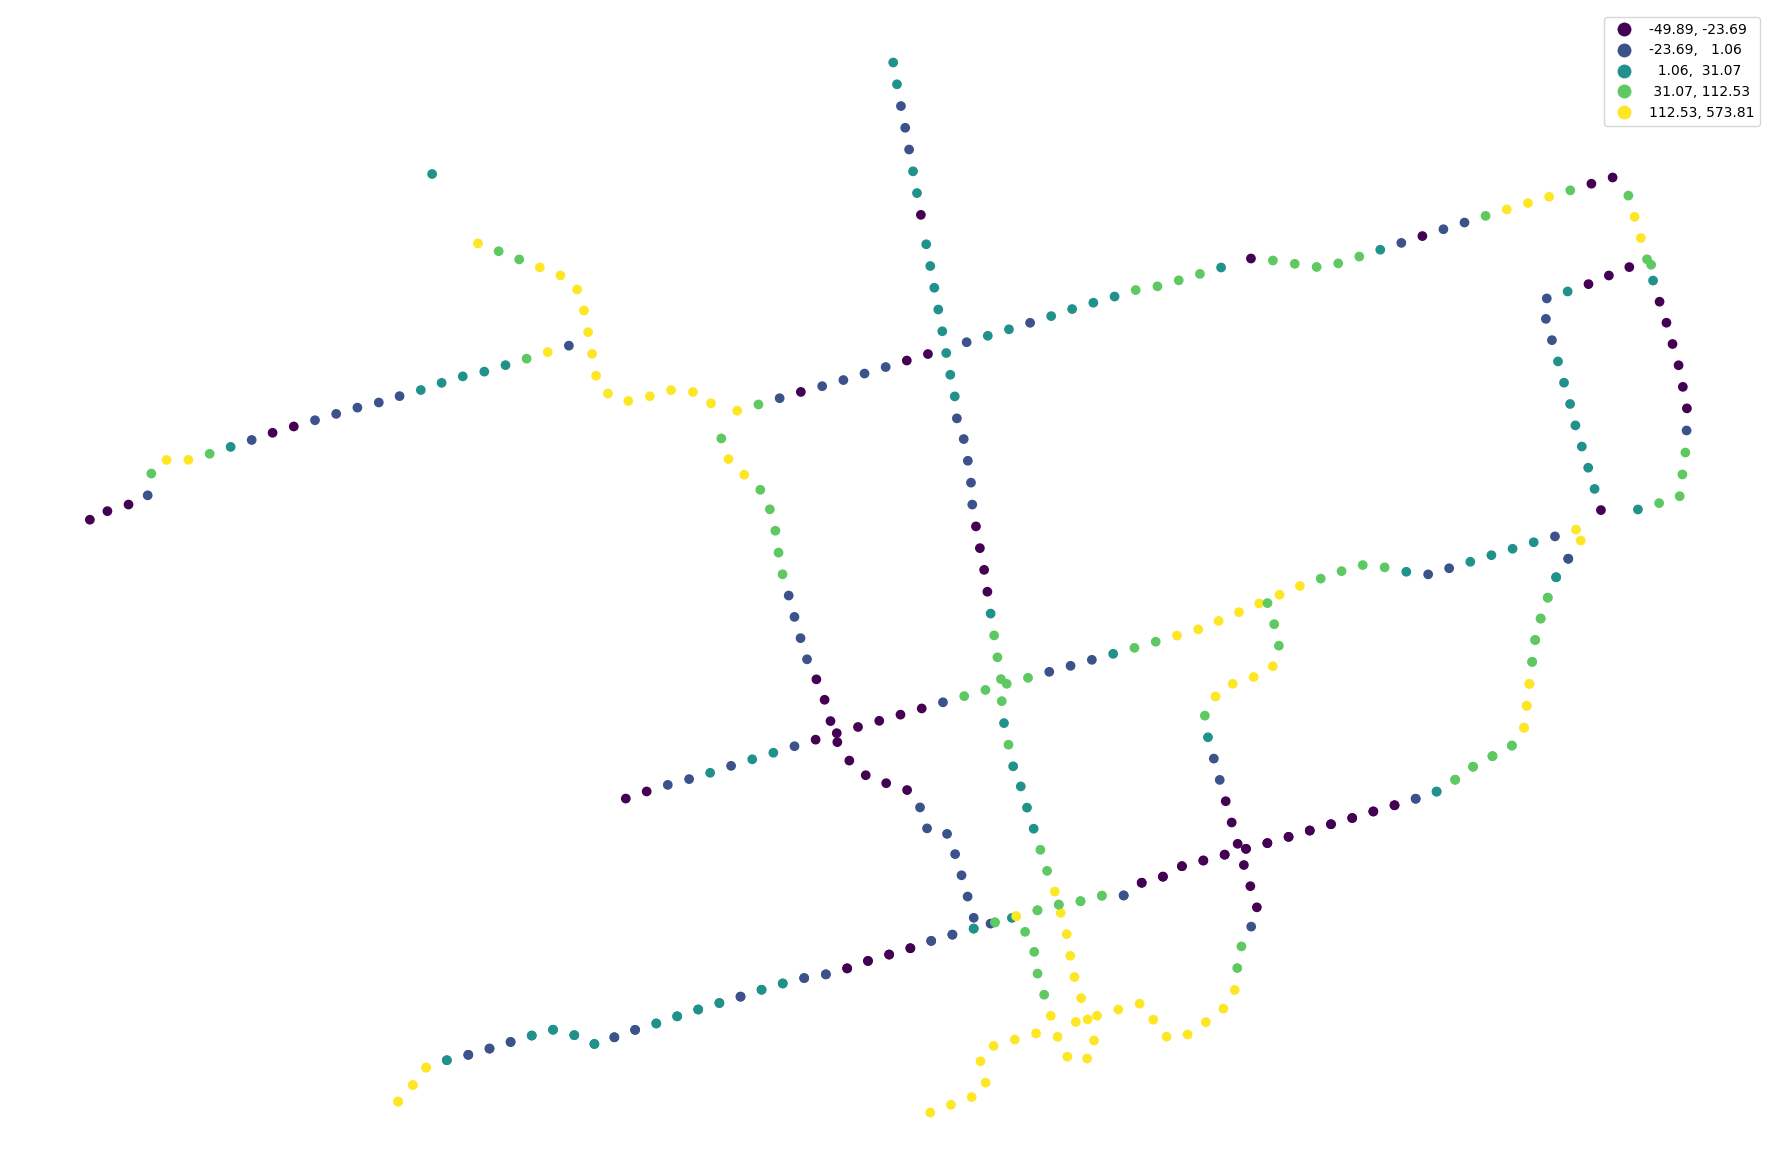

In [ ]:
"""ax = point_400.plot(color='red', zorder=4, figsize=(10, 10))
service.plot(ax=ax, zorder=3, markersize = 3, color = "blue")"""

ax = point_400_join.plot(column = 'Percent Pop Chg',zorder = 3, scheme='quantiles', figsize=(50, 15), legend=True)
#transit_buff_2021_merge.plot(ax=ax, column = 'Adjusted Weighted Income', zorder=1, scheme='quantiles', legend=True)
#point_400.plot(ax=ax, zorder=2, color = "red")
ax.set_axis_off()

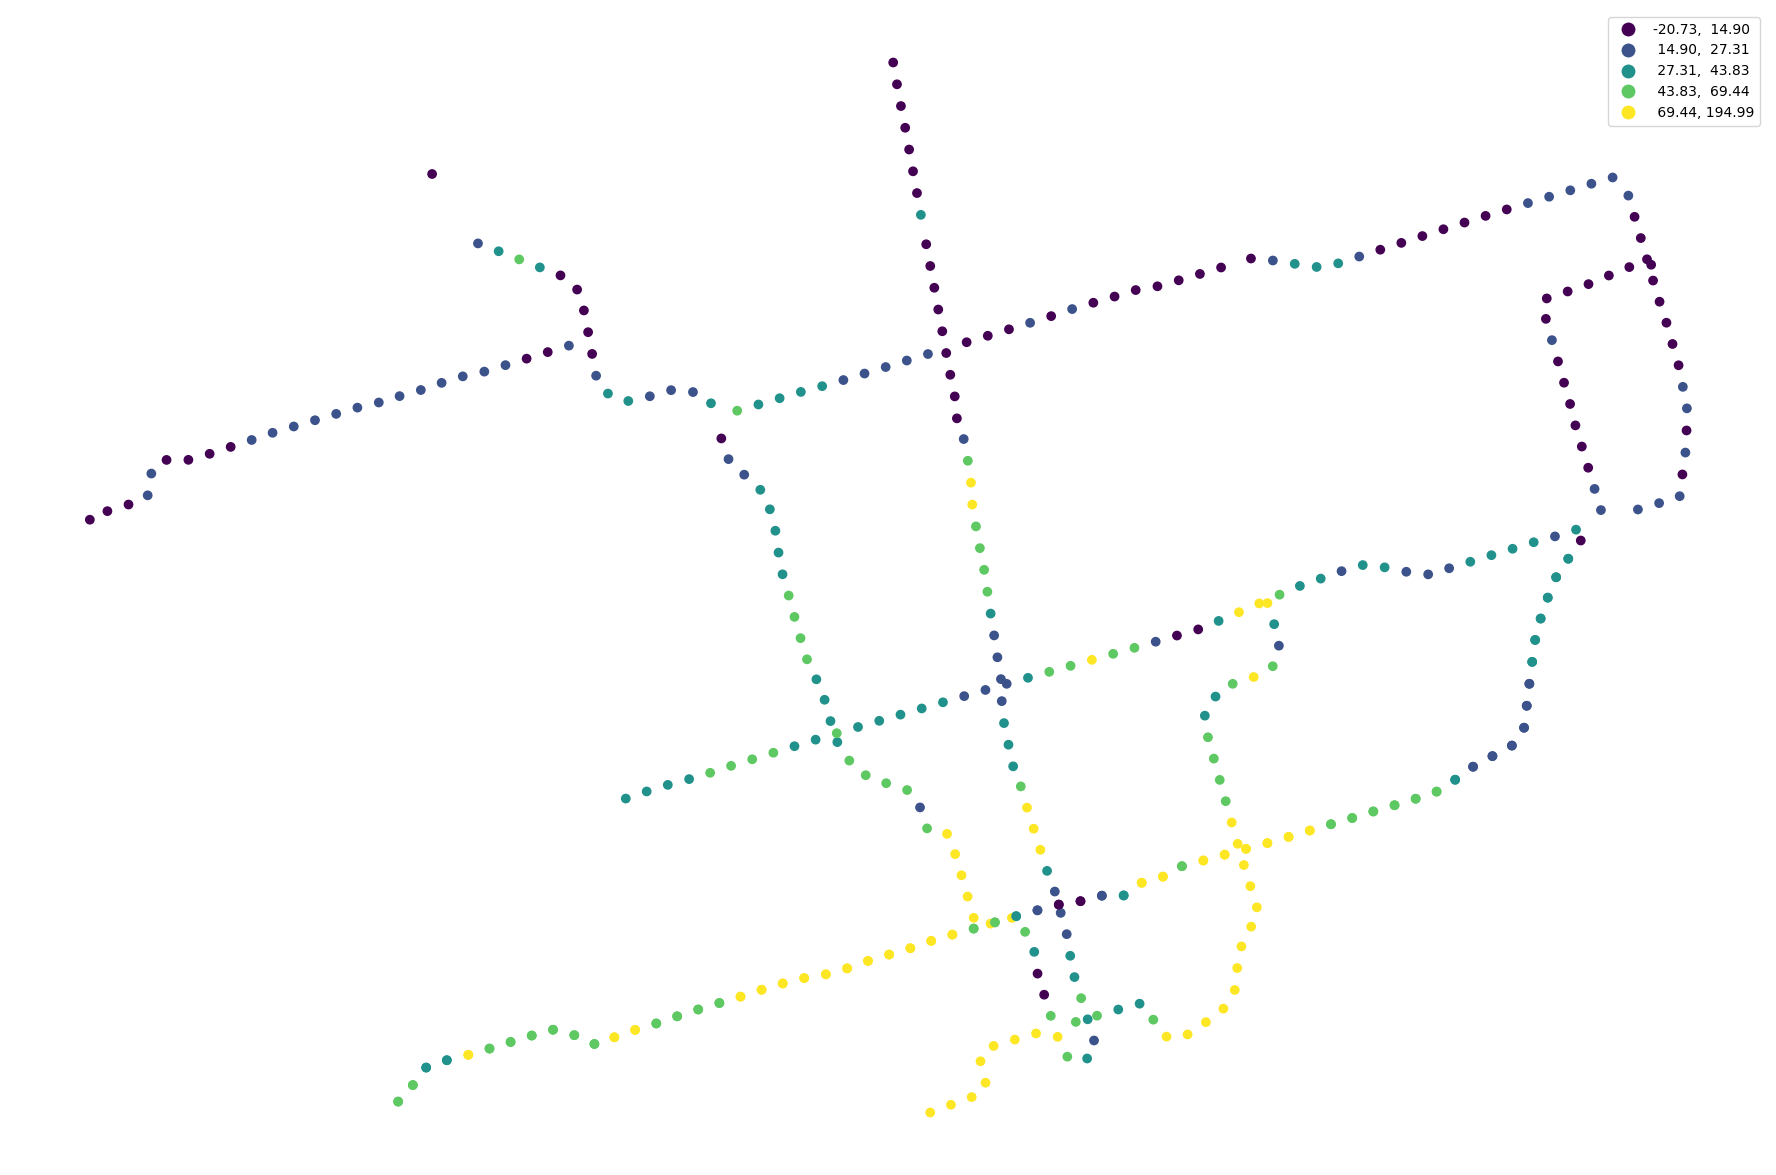

In [ ]:
ax = point_400_join.plot(column = 'Percent Income Chg',zorder = 2, scheme='quantiles', legend=True,figsize=(50, 15))
#point_400.plot(ax=ax, zorder=1, color = "red")
ax.set_axis_off()